In [2]:
custom_map_8x8 = [
    list("SFFFFFFF"),
    list("HFFFHFFF"),
    list("FFFFFFFH"),
    list("FFFFFFFF"),
    list("FFFFFFFF"),
    list("FFFFFFFF"),
    list("FHFFHFFF"),
    list("FFFFFFFF"),
    list("FFFFFFFF"),
    list("FFFFFFFG")
]
custom_map_big = [
    list(row) for row in [
        "SFFHFFFFFFFHFFFFFFFFFFFHFFF",
        "FFFFFFFFFFFFFFFFFFFFHFFFFFF",
        "FFFHFFFFFFFFFFFFHFFFFFFFFFF",
        "FFFFFFFFFFFFFFHFFFFFFFFFFFF",
        "FFFFFFFFFFFFFFFFFFFFFFFFFFF",
        "FFFFFFFFFFFFFFFFFFHFFFFFFFF",
        "FFFFFFFFFFFFFFHFHFFFFFFFFHF",
        "HHHFFFFFFFFHFFFHFFFFFFFFFFF",
        "HFFFFFFFFFFFFFFFFFHFFHFFHHF",
        "FHFHFFFFFFFHHFFFFFFFFFFFFFF",
        "FFHHFFFFFFFFFFFFFFFFFFFFFFF",
        "FFFHFFFHFFFFFFFFFFFFFFFFFFF",
        "FFFHFFFFFFFFFFFFFFFFFFFFHFF",
        "HFFFHFFFHHHFFHFFFFFFFHFFFFF",
        "FFFFFFFFFFFFFFFFFFFFFFFFFFF",
        "FFFFFFFFHFFFFFFFFFFFFFHFFFF",
        "FFFFFFFFFFFFFFFFFHFHFFHFFFF",
        "FFHFFFFFHHFFFFHFFHFFFFFFFFH",
        "FFFHFFFFFFFFFFFFFFFFFFFFFFF",
        "FFFFFHFFFFFFFFFFFHFFFFFFFFF",
        "FFFFFFFFFFFFFFFFFFFFFFFFFFF",
        "FFFHFFFFFFFFFFFFFFFHFFFFFHHF",
        "FFFFFFFHFFFFFFFFFFFFFFHFFFF",
        "FFFFFFFFFFHFHHFFFFFFFFFFFFH",
        "FFFFFFFFFFFFFFFFFFFFFFFFFFH",
        "FFFFFFFFFFFFFFFHFFFFFHFFFFG"
    ]
]

In [ ]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time

class CustomFrozenLakeEnv(gym.Env):
    def __init__(self, grid, slip_prob=0.2):
        super().__init__()
        self.map = grid
        self.nrow = len(self.map)
        self.ncol = len(self.map[0])
        self.nS = self.nrow * self.ncol
        self.nA = 4
        self.slip_prob = slip_prob

        self.action_space = spaces.Discrete(self.nA)
        self.observation_space = spaces.Discrete(self.nS)
        self.pos_to_state = lambda r, c: r * self.ncol + c
        self.state_to_pos = lambda s: (s // self.ncol, s % self.ncol)
        self.state = None
        self.P = self._build_transition_matrix()

    def _build_transition_matrix(self):
        P = {s: {a: [] for a in range(self.nA)} for s in range(self.nS)}
        for r in range(self.nrow):
            for c in range(self.ncol):
                s = self.pos_to_state(r, c)
                tile = self.map[r][c]
                for a in range(self.nA):
                    transitions = []
                    directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]  # L, D, R, U

                    for i, (dr, dc) in enumerate(directions):
                        prob = 1 - self.slip_prob if i == a else self.slip_prob / 3.0
                        new_r = min(max(r + dr, 0), self.nrow - 1)
                        new_c = min(max(c + dc, 0), self.ncol - 1)
                        new_s = self.pos_to_state(new_r, new_c)
                        new_tile = self.map[new_r][new_c]
                        reward = 1.0 if new_tile == 'G' else -1.0 if new_tile == 'H' else 0
                        done = new_tile in "GH"
                        transitions.append((prob, new_s, reward, done))

                    P[s][a] = transitions
        return P

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = (0, 0)
        return self._get_obs(), {}

    def step(self, action):
        r, c = self.state
        directions = [(0, -1), (1, 0), (0, 1), (-1, 0)]  # L, D, R, U

        if np.random.rand() < self.slip_prob:
            action = np.random.choice([a for a in range(self.nA) if a != action])

        dr, dc = directions[action]
        r = min(max(r + dr, 0), self.nrow - 1)
        c = min(max(c + dc, 0), self.ncol - 1)
        self.state = (r, c)

        tile = self.map[r][c]
        reward = 1.0 if tile == 'G' else -1.0 if tile == 'H' else 0
        done = tile in "GH"
        return self._get_obs(), reward, done, False, {}

    def _get_obs(self):
        r, c = self.state
        return self.pos_to_state(r, c)
    



helper function

In [ ]:
import time

def greedy_action(Q):
    return np.random.choice(np.flatnonzero(Q == Q.max()))

In [5]:
def monte_carlo(env, episodes, gamma=0.99, epsilon_start=1, epsilon_end=0.05):
    Q = np.zeros((env.observation_space.n, env.action_space.n))  
    N = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))
        state, _ = env.reset()
        episode = []
        done = False
        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else greedy_action(Q[state])
            next_state, reward, done, _, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state

        G = 0
        visited = set()
        total_reward = 0
        for t in reversed(range(len(episode))):
            s, a, r = episode[t]
            G = gamma * G + r
            total_reward += r
            if (s, a) not in visited:
                visited.add((s, a))
                N[s, a] += 1
                Q[s, a] += (G - Q[s, a]) / N[s, a]
        rewards.append(total_reward)

    return Q, rewards




In [ ]:
def q_learning(env, episodes=1000, alpha=0.4, gamma=0.99, epsilon_start=0.5, epsilon_end=0.05):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = env.action_space.sample() if np.random.rand() < epsilon else greedy_action(Q[state])
            next_state, reward, done, _, _ = env.step(action)
            Q[state, action] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state, action])
            total_reward += reward
            state = next_state
        rewards.append(total_reward)

    return Q, rewards



In [ ]:
def sarsa(env, episodes=1000, alpha=0.2, gamma=0.95, epsilon_start=1, epsilon_end=0.005):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(episodes):
        epsilon = max(epsilon_end, epsilon_start * (0.995 ** ep))
        state, _ = env.reset()
        action = env.action_space.sample() if np.random.rand() < epsilon else greedy_action(Q[state])
        total_reward = 0
        done = False
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = env.action_space.sample() if np.random.rand() < epsilon else greedy_action(Q[next_state])
            Q[state, action] += alpha * (reward + gamma * Q[next_state, next_action] - Q[state, action])
            total_reward += reward
            state, action = next_state, next_action
        rewards.append(total_reward)

    return Q, rewards



In [15]:
def policy_iteration(env, gamma=0.99, theta=1e-5):
    policy = np.zeros(env.nS, dtype=int)
    V = np.zeros(env.nS)
    is_stable = False
    P = env.P

    while not is_stable:
        
        while True:
            delta = 0
            for s in range(env.nS):
                v = V[s]
                a = policy[s]
                V[s] = sum([p * (r + gamma * V[s_]) for p, s_, r, _ in P[s][a]])
                delta = max(delta, abs(v - V[s]))
            if delta < theta:
                break

        
        is_stable = True
        for s in range(env.nS):
            old_action = policy[s]
            q_vals = np.array([sum([p * (r + gamma * V[s_]) for p, s_, r, _ in P[s][a]]) for a in range(env.nA)])
            policy[s] = np.argmax(q_vals)
            if old_action != policy[s]:
                is_stable = False
    return policy



In [16]:
def value_iteration(env, gamma=0.99, theta=1e-5):
    V = np.zeros(env.nS)
    P = env.P
    while True:
        delta = 0
        for s in range(env.nS):
            v = V[s]
            V[s] = max([sum([p * (r + gamma * V[s_]) for p, s_, r, _ in P[s][a]]) for a in range(env.nA)])
            delta = max(delta, abs(v - V[s]))
        if delta < theta:
            break
    policy = np.zeros(env.nS, dtype=int)
    for s in range(env.nS):
        q_vals = np.array([sum([p * (r + gamma * V[s_]) for p, s_, r, _ in P[s][a]]) for a in range(env.nA)])
        policy[s] = np.argmax(q_vals)

    return policy

Algorithm            Time (s)    Avg Reward   Avg Ep Len   Episodes
----------------------------------------------------------------------
Monte Carlo          12.13       0.400        30.030       40000
SARSA                0.36        0.670        38.230       2000
Q-learning           0.44        -0.020       20.580       2000
Policy Iteration     0.25        0.360        16.540       14
Value Iteration      0.31        0.560        18.160       14


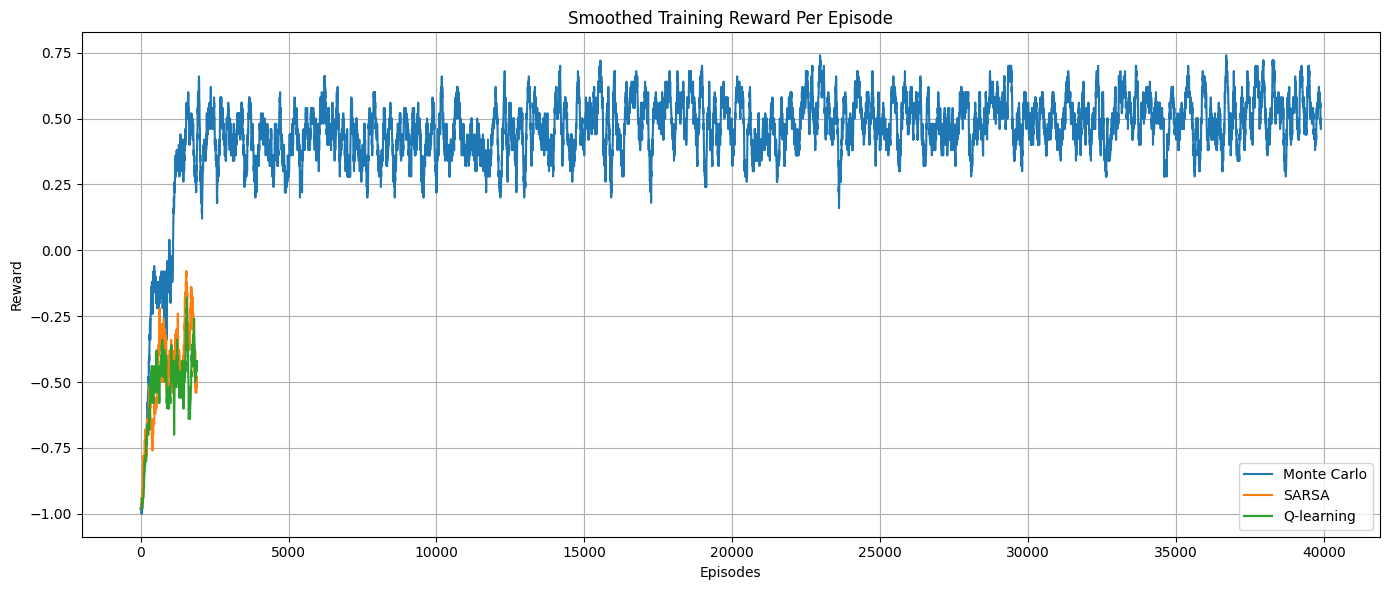

In [25]:
import time
import numpy as np
import matplotlib.pyplot as plt

results = {}

# === Reward smoothing ===
def smooth(y, box_size=100):
    if len(y) < box_size:
        return y  
    box = np.ones(box_size) / box_size
    return np.convolve(y, box, mode='valid')


def evaluate_policy(env, policy, test_episodes=100, max_steps=500):
    total_rewards = []
    total_steps = []
    for _ in range(test_episodes):
        state, _ = env.reset()
        done = False
        steps = 0
        total_reward = 0
        while not done and steps < max_steps:
            action = policy[state]
            state, reward, done, _, _ = env.step(action)
            total_reward += reward
            steps += 1
        total_rewards.append(total_reward)
        total_steps.append(steps)
    return np.mean(total_rewards), np.mean(total_steps)


def run_and_evaluate(name, algo_fn, env, episodes=4000, is_model_based=False, test_episodes=100):
    start_time = time.time()

    if is_model_based:
        policy = algo_fn(env)
        end_time = time.time()
        avg_reward, avg_steps = evaluate_policy(env, policy, test_episodes)
        reward_history = []
    else:
        Q, reward_history = algo_fn(env, episodes)
        end_time = time.time()
        policy = np.argmax(Q, axis=1)
        avg_reward, avg_steps = evaluate_policy(env, policy, test_episodes)

    results[name] = {
        "rewards": reward_history,
        "time": end_time - start_time,
        "avg_reward": avg_reward,
        "avg_steps": avg_steps,
        "episodes": episodes
    }

    print(f"{name:<20} {end_time - start_time:<10.2f}  {avg_reward:<12.3f} {avg_steps:<12.3f} {episodes}")



print(f"{'Algorithm':<20} {'Time (s)':<10}  {'Avg Reward':<12} {'Avg Ep Len':<12} {'Episodes'}")
print("-" * 70)

env = CustomFrozenLakeEnv(custom_map_8x8, slip_prob=0.2)

run_and_evaluate("Monte Carlo", monte_carlo, env, episodes=40000)
run_and_evaluate("SARSA", sarsa, env, episodes=2000)
run_and_evaluate("Q-learning", q_learning, env, episodes=2000)
run_and_evaluate("Policy Iteration", policy_iteration, env, episodes=14, is_model_based=True)
run_and_evaluate("Value Iteration", value_iteration, env, episodes=14, is_model_based=True)


plt.figure(figsize=(14, 6))
for name, data in results.items():
    if len(data["rewards"]) == 0:
        continue  
    smoothed = smooth(data["rewards"])
    plt.plot(smoothed, label=name)

plt.title("Smoothed Training Reward Per Episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



Monte Carlo          202.04      -0.550       353.160      4000
SARSA                290.00      -0.020       492.390      12000
Q-learning           19.66       -0.090       474.990      12000
Policy Iteration     3.91        0.820        57.510       40
Value Iteration      3.16        0.740        55.080       40


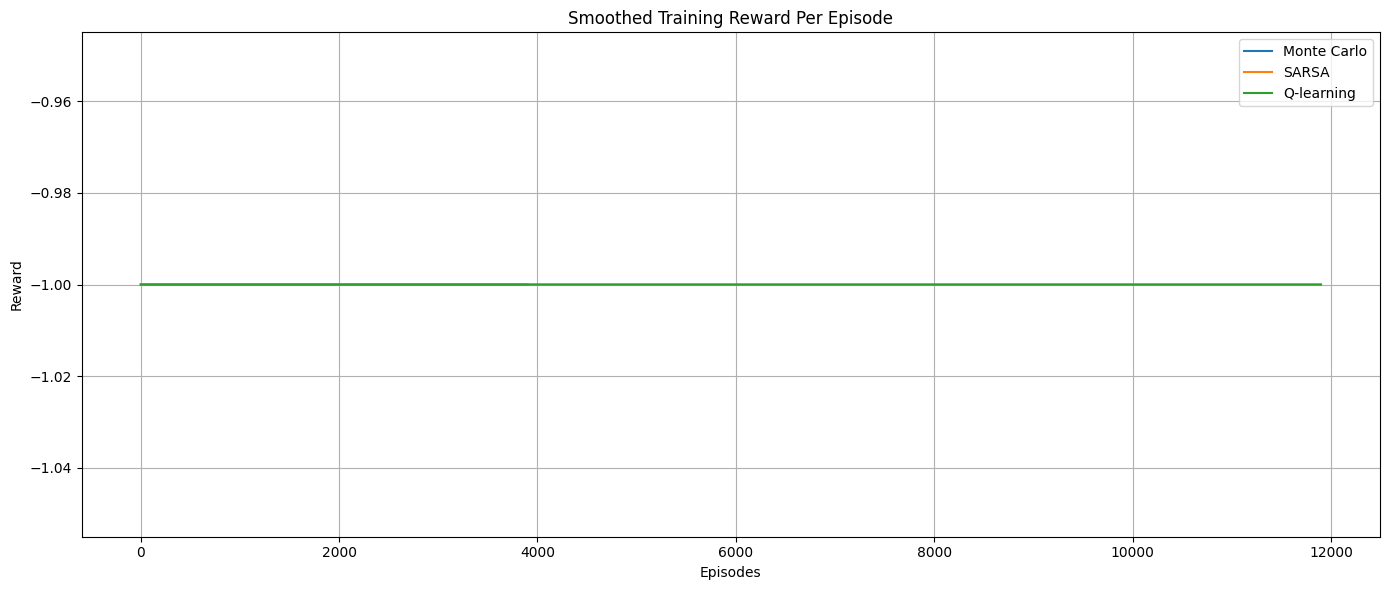

In [29]:

env = CustomFrozenLakeEnv(custom_map_big, slip_prob=0.1)

run_and_evaluate("Monte Carlo", monte_carlo, env, episodes=4000)
run_and_evaluate("SARSA", sarsa, env, episodes=12000)
run_and_evaluate("Q-learning", q_learning, env, episodes=12000)
run_and_evaluate("Policy Iteration", policy_iteration, env, episodes=40, is_model_based=True)
run_and_evaluate("Value Iteration", value_iteration, env, episodes=40, is_model_based=True)

plt.figure(figsize=(14, 6))
for name, data in results.items():
    if len(data["rewards"]) == 0:
        continue 
    smoothed = smooth(data["rewards"])
    plt.plot(smoothed, label=name)

plt.title("Smoothed Training Reward Per Episode")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

